In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from os.path import join

In [2]:
from utils import videoReader
from matching_video import Match_Video
from matching_frame import Match_Frame

In [3]:
# loads the image and converts it to rgb
def imread(name, folder="../data/img"):
    img = cv2.imread(join(folder, name))
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# plots image
def imshow(img, shape=None):
    if shape != None: plt.figure(figsize=shape)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    
# plotting many images
def plot(imgs, shape=None):
    if shape != None: plt.figure(figsize=shape)
    m = len(imgs)
    for i in range(1, m+1):
        plt.subplot(1, m, i)
        imshow(imgs[i-1])

(99, 175, 3)


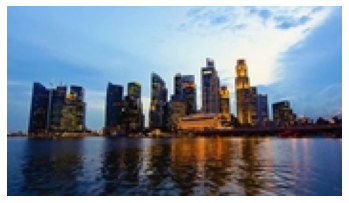

In [4]:
sgp = imread('singapore_25.jpg')
print(sgp.shape)
imshow(sgp)

In [5]:
# press q to quit
cap = videoReader('../data/videos/dubai.avi', True)

In [6]:
# matching video
match_arr = Match_Video().findBestVideo(sgp)
print(match_arr)

[['119.75' '../data/videos/dubai.avi']]


1224 0.03280819003176434
(99, 175, 3)


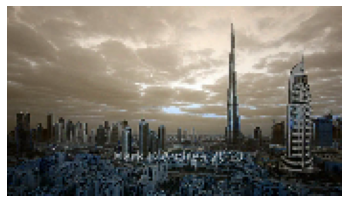

In [7]:
# matching frame of video
img, frame_no, min_dist = Match_Frame().best_distribution_frame(sgp, match_arr[0][1])
print(frame_no, min_dist)
print(img.shape)
imshow(img)

(99, 175, 3)


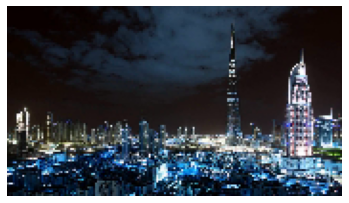

In [8]:
# target frame
cap = videoReader('../data/videos/dubai.avi')
cap.set(cv2.CAP_PROP_POS_FRAMES, 100)
_, Target = cap.read()
Target = cv2.resize(Target, (img.shape[1], img.shape[0]), cv2.INTER_CUBIC)
print(Target.shape)
imshow(Target)

In [9]:
def Vk(I):
    return I.reshape((-1, 3)).T

def Vdk(I):
    vk = Vk(I)
    return vk, np.vstack([vk, np.ones((1, vk.shape[-1]))])

def affine_transform_k(Ik, Mk, Tk, G, epsilon, gamma):
    vIk, vdIk = Vdk(Ik)
    vMk, vdMk = Vdk(Mk)
    vTk, vdTk = Vdk(Tk)
    
    B = np.linalg.pinv(vdIk @ vdIk.T + epsilon * vdMk @ vdMk.T + gamma * np.eye(4))
    M = np.eye(vIk.shape[-1]) - vdIk.T @ B @ vdIk
    u = (epsilon * vTk @ vdMk.T + gamma * G) @ B @ vdIk
    return np.clip((u @ np.linalg.pinv(M)).astype('uint8'), 0, 255).T.reshape(Ik.shape)

def affine_G(M, T):
    return Vk(T) @ np.linalg.pinv(Vdk(M)[1])
    
def affine_transform(I, M, T, window=(5, 5), epsilon=1e-10, gamma=1):
    G = affine_G(M, T)
    O = np.zeros(I.shape, dtype='uint8')
    for i in range(0, I.shape[0], window[0]):
        for j in range(0, I.shape[1], window[1]):
            O[i:i+window[0], j:j+window[1]] = affine_transform_k(I[i:i+window[0], j:j+window[1]], M[i:i+window[0], j:j+window[1]], T[i:i+window[0], j:j+window[1]], G, epsilon, gamma)
    return O[:I.shape[0] - I.shape[0] % window[0], :I.shape[1] - I.shape[1] % window[1]]    

CPU times: user 301 ms, sys: 14.9 ms, total: 316 ms
Wall time: 735 ms


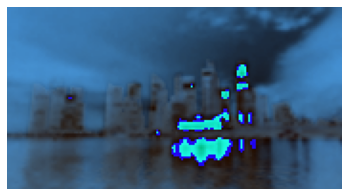

In [10]:
%time imshow(affine_transform(sgp.astype('float64'), img.astype('float64'), Target.astype('float64')))

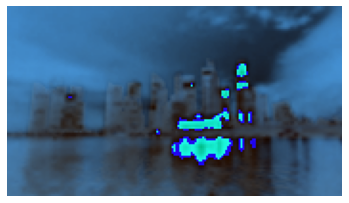

In [18]:
# global affine transformation
G = affine_G(img, Target)
out = (G @ Vdk(sgp)[1]).T.reshape(img.shape).astype('uint8')
imshow(out)

## Matlab in python

In [11]:
from oct2py import Oct2Py
oc = Oct2Py()


script = "function y = myScript(x)\n" \
         "    y = x-5" \
         "end"

with open("myScript.m","w+") as f:
    f.write(script)

oc.myScript(7)

y =  2


2.0

In [12]:
import torch
torch.__version__

'1.5.1'

In [57]:
def regression_k(Ik, Mk, Tk, G, epsilon, gamma, num_epochs, lr):
    vdIk, vdMk, vTk = Vdk(Ik)[1], Vdk(Mk)[1], Vk(Tk)
    vdIk, vdMk, vTk = torch.from_numpy(vdIk).float(), torch.from_numpy(vdMk).float(), torch.from_numpy(vTk).float()
    G = torch.from_numpy(G).float()
    Ak = torch.rand(3, 4, requires_grad=True).float()
    vOk = torch.rand(*vTk.shape, requires_grad=True).float()
    for epoch in range(num_epochs):
        fun = torch.sum((vOk - Ak @ vdIk) ** 2) + epsilon * torch.sum((vTk - Ak @ vdMk) ** 2) + gamma * torch.sum((Ak - G) ** 2)
        fun.backward()
        with torch.no_grad():
            Ak -= lr * Ak.grad
            vOk -= lr * vOk.grad
            Ak.grad.zero_()
            vOk.grad.zero_()
    return vOk.detach().numpy().T.reshape(Ik.shape).astype('uint8')

def regression(I, M, T, window=(5, 5), epsilon=1e-10, gamma=1, num_epochs=100, lr=1):
    G = affine_G(M, T)
    O = np.zeros(I.shape, dtype='uint8')
    for i in range(0, I.shape[0], window[0]):
        for j in range(0, I.shape[1], window[1]):
            O[i:i+window[0], j:j+window[1]] = regression_k(I[i:i+window[0], j:j+window[1]], M[i:i+window[0], j:j+window[1]], T[i:i+window[0], j:j+window[1]], G, epsilon, gamma, num_epochs, lr)
    return O[:I.shape[0] - I.shape[0] % window[0], :I.shape[1] - I.shape[1] % window[1]]    

CPU times: user 26.1 s, sys: 886 ms, total: 27 s
Wall time: 26.6 s


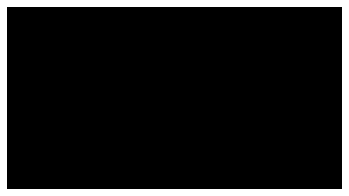

In [56]:
%time imshow(regression(sgp, img, Target))